In [ ]:
%%capture output

!pip install lightgbm[scikit-learn]
!pip install eli5

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import eli5

import lightgbm
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Задание 1

In [ ]:
!gdown 1XkKOS6jbke3JYWTj8V_xS46txe820rZ_ -O train.csv
!gdown 1HVlLLVkAhofK38jmBVPXzT9lPYq63Q7Q -O test.csv

Downloading...
From: https://drive.google.com/uc?id=1XkKOS6jbke3JYWTj8V_xS46txe820rZ_
To: /content/train.csv
100% 122k/122k [00:00<00:00, 38.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HVlLLVkAhofK38jmBVPXzT9lPYq63Q7Q
To: /content/test.csv
100% 63.9k/63.9k [00:00<00:00, 84.1MB/s]


In [ ]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## EDA

In [ ]:
# для начала посмотрим, есть ли в нашем датасете отсутствующие значения
data.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [ ]:
# теперь посмотрим есть ли дупликаты

data.duplicated().sum()

0

Text(0.5, 1.0, 'Корреляционная матрица')

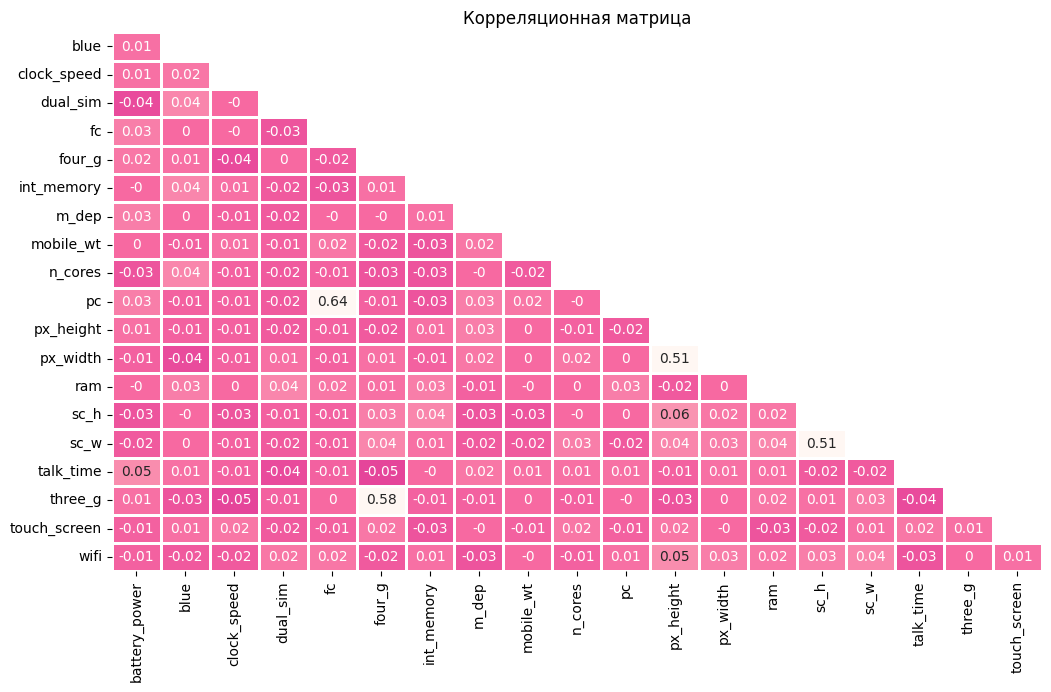

In [ ]:
corr_mat = data.iloc[:, :-1].corr().round(2)
f, ax = plt.subplots(figsize=(12,7))
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
mask = mask[1:,:-1]
corr = corr_mat.iloc[1:,:-1].copy()
sns.heatmap(corr,mask=mask,vmin=-0.3,vmax=0.3,center=0,
            cmap='RdPu_r',square=False, lw=2, annot=True, cbar=False)
ax.set_title('Корреляционная матрица')

In [ ]:
# видим, что у нас есть несколько пар которые коррелируют друг с другом, уберем ее чтобы облегчить участь для нашей модели
data_to_exclude = ["pc", "fc", "four_g", "three_g", "px_height", "px_width", "sc_h", "sc_w"]
data_mod = data.loc[:, list(set(data.columns) - set(data_to_exclude))]
data_mod.head()

,touch_screen,price_range,n_cores,int_memory,clock_speed,ram,wifi,dual_sim,m_dep,mobile_wt,battery_power,blue,talk_time
0,0,1,2,7,2.2,2549,1,0,0.6,188,842,0,19
1,1,2,3,53,0.5,2631,0,1,0.7,136,1021,1,7
2,1,2,5,41,0.5,2603,0,1,0.9,145,563,1,9
3,0,2,6,10,2.5,2769,0,0,0.8,131,615,1,11
4,1,1,2,44,1.2,1411,0,0,0.6,141,1821,1,15


In [ ]:
# теперь посмотрим на базовые статистические данные фич
data_mod.describe()

,touch_screen,price_range,n_cores,int_memory,clock_speed,ram,wifi,dual_sim,m_dep,mobile_wt,battery_power,blue,talk_time
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000
mean,0.503000,1.500000,4.520500,32.046500,1.522250,2124.213000,0.507000,0.509500,0.501750,140.249000,1238.518500,0.4950,11.011000
std,0.500116,1.118314,2.287837,18.145715,0.816004,1084.732044,0.500076,0.500035,0.288416,35.399655,439.418206,0.5001,5.463955
min,0.000000,0.000000,1.000000,2.000000,0.500000,256.000000,0.000000,0.000000,0.100000,80.000000,501.000000,0.0000,2.000000
25%,0.000000,0.750000,3.000000,16.000000,0.700000,1207.500000,0.000000,0.000000,0.200000,109.000000,851.750000,0.0000,6.000000
50%,1.000000,1.500000,4.000000,32.000000,1.500000,2146.500000,1.000000,1.000000,0.500000,141.000000,1226.000000,0.0000,11.000000
75%,1.000000,2.250000,7.000000,48.000000,2.200000,3064.500000,1.000000,1.000000,0.800000,170.000000,1615.250000,1.0000,16.000000
max,1.000000,3.000000,8.000000,64.000000,3.000000,3998.000000,1.000000,1.000000,1.000000,200.000000,1998.000000,1.0000,20.000000


In [ ]:
# в первую очередь мы сравниваем min & 25% percentile и max & 75% percentile, чтобы обнаружить выбросы
# видим, что выбросов как таковых не наблюдается, сделаем дополнительную проверку

data_mod.skew() # отклонений не наблюдается

touch_screen    -0.012009
price_range      0.000000
n_cores          0.003628
int_memory       0.057889
clock_speed      0.178084
ram              0.006628
wifi            -0.028024
dual_sim        -0.038035
m_dep            0.089082
mobile_wt        0.006558
battery_power    0.031898
blue             0.020016
talk_time        0.009512
dtype: float64

In [ ]:
# Однако значения между фичами сильно отличаются, кроме того некоторые из них являются вообще категориальными данными, а остальные непрерывными
# нам нужно их как-то за'scale'ить -- просто нормализуем в интервал [0, 1]
X = data_mod.drop('price_range', axis=1)
y = data_mod['price_range'].copy()

min_max_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
min_max_scaler.fit(X)
X_norm = pd.DataFrame(min_max_scaler.transform(X), index=X.index, columns=X.columns)
X_norm.head()

,touch_screen,n_cores,int_memory,clock_speed,ram,wifi,dual_sim,m_dep,mobile_wt,battery_power,blue,talk_time
0,0.0,0.142857,0.080645,0.68,0.612774,1.0,0.0,0.555556,0.900000,0.227789,0.0,0.944444
1,1.0,0.285714,0.822581,0.00,0.634687,0.0,1.0,0.666667,0.466667,0.347361,1.0,0.277778
2,1.0,0.571429,0.629032,0.00,0.627205,0.0,1.0,0.888889,0.541667,0.041416,1.0,0.388889
3,0.0,0.714286,0.129032,0.80,0.671566,0.0,0.0,0.777778,0.425000,0.076152,1.0,0.500000
4,1.0,0.142857,0.677419,0.28,0.308658,0.0,0.0,0.555556,0.508333,0.881764,1.0,0.722222


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=42)

## Training

In [ ]:
lg = LogisticRegression(max_iter=400)
lg.fit(X_train, y_train)
preds_lg = lg.predict(X_test)

In [ ]:
# мы будем использовать MAE по двум причинам:
# 1) у нас нет аномалий, поэтому заботиться нам о них не нужно
# 2) так как у нас price_range по сути хранить категориальные данные, то нам важно точность их предсказания

MAE = mean_absolute_error(preds_lg, y_test)
f'{MAE = }'

'MAE = 0.2025'

In [ ]:
# посмотрим на важность признаков

eli5.show_weights(lg, feature_names=lg.feature_names_in_)

In [ ]:
cl = LGBMClassifier()
cl.fit(X_train, y_train)
preds_cl = cl.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 12
[LightGBM] [Info] Start training from score -1.398873
[LightGBM] [Info] Start training from score -1.364044
[LightGBM] [Info] Start training from score -1.366492
[LightGBM] [Info] Start training from score -1.416754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
MAE = mean_absolute_error(preds_cl, y_test)
f'{MAE = }'

'MAE = 0.2025'

In [ ]:
eli5.show_weights(cl)

Weight,Feature
0.6572,ram
0.1730,battery_power
0.0377,mobile_wt
0.0338,int_memory
0.0223,clock_speed
0.0222,talk_time
0.0169,m_dep
0.0167,n_cores
0.0069,dual_sim
0.0050,blue


## Hyperparameters tuning

In [ ]:
%%capture lg_hp_tuning

logreg = LogisticRegression()

grid={"C":np.logspace(-3,3,7),
      "penalty":["l1","l2"]} # l1 lasso l2 ridge

logreg_cv=GridSearchCV(logreg,
                       grid,
                       scoring='neg_mean_absolute_error',
                       cv=10,)
logreg_cv.fit(X_train, y_train)

In [ ]:
lg = LogisticRegression(max_iter=400, **logreg_cv.best_params_)
lg.fit(X_train, y_train)
preds_lg = lg.predict(X_test)

MAE = mean_absolute_error(preds_lg, y_test)
f'{MAE = }'

'MAE = 0.2075'

# Задание 2

In [ ]:
!gdown 1TJI9IVaZQtaTJUezLrC3WaQ-eEC40AGG -O smoke_detection_iot.csv

Downloading...
From: https://drive.google.com/uc?id=1TJI9IVaZQtaTJUezLrC3WaQ-eEC40AGG
To: /content/smoke_detection_iot.csv
100% 5.83M/5.83M [00:00<00:00, 115MB/s]


In [ ]:
_smoke = pd.read_csv('smoke_detection_iot.csv')
_smoke

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


## EDA

In [ ]:
# сразу можно выкинуть бесполезные столбцы
smoke = _smoke.drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)
smoke

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0


In [ ]:
# бустер очень ругается за наши названия, я их обрежу заранее
cols_slicer = lambda columns: [sl.split('[')[0] for sl in columns]
smoke.columns = cols_slicer(smoke.columns)
smoke

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0


In [ ]:
# проверим на нулевые значения
smoke.isnull().sum()

Temperature    0
Humidity       0
TVOC           0
eCO2           0
Raw H2         0
Raw Ethanol    0
Pressure       0
PM1.0          0
PM2.5          0
NC0.5          0
NC1.0          0
NC2.5          0
Fire Alarm     0
dtype: int64

In [ ]:
# теперь на дубликаты

if smoke.duplicated().sum() > 0:
  print('duplicates present')
  smoke.drop_duplicates(inplace=True)
else:
  print('no duplicates')

duplicates present


In [ ]:
smoke.describe()

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
count,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000,62628.000000
mean,15.970071,48.539618,1942.118318,670.029236,12942.457240,19754.226480,938.627683,100.597455,184.473592,491.478842,203.592917,80.051597,0.714648
std,14.359670,8.865484,7811.706379,1905.915320,272.468026,609.497498,1.331352,922.538807,1976.336903,4265.728511,2214.773627,1083.400393,0.451585
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.994000,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,0.000000
50%,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,1.000000
75%,25.407250,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,1.000000
max,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,1.000000


In [ ]:
smoke.skew() # данные сильно смещены вправо для столбцов CO2[ppm] и PM, NC

Temperature    -0.619856
Humidity       -2.460774
TVOC            6.776791
eCO2           12.459611
Raw H2         -2.910073
Raw Ethanol    -1.684782
Pressure       -3.604107
PM1.0          10.752490
PM2.5          14.145996
NC0.5          10.041158
NC1.0          14.447263
NC2.5          17.736443
Fire Alarm     -0.950674
dtype: float64

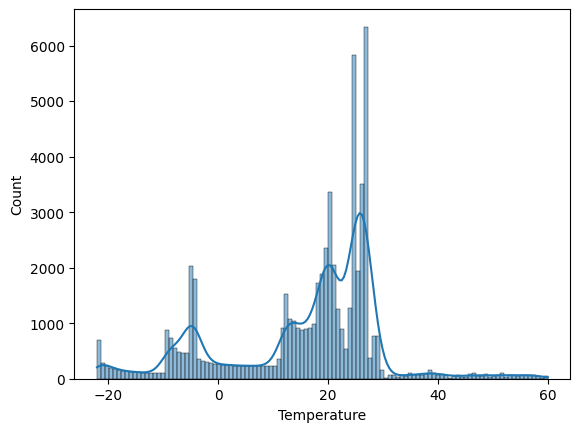

In [ ]:
# видим что у нас как минимум в столбце температура имеются выбросы, так как мин значение и 25 квартель сильно отличаются
# также среднее макс значение сильно отличается от среднего
# аналогичная ситуация и со всеми другими переменными
# посмотрим график для нескольких столбцов

sns.histplot(smoke['Temperature'], kde=True) # с остальными данными ситуация еще хуже
plt.show()

In [ ]:
# однако эти данные мы выкинуть не можешь, потому что очевидно, что взрывы именно с этими аномалиями и связаны
# поэтому будем учитывать при выборе метрики просто и стандартизируем данные
X_smoke = smoke.drop('Fire Alarm', axis=1)
y_smoke = smoke['Fire Alarm'].copy()


std_scaler = StandardScaler()
std_scaler.fit(X_smoke)
X_smoke_std = pd.DataFrame(std_scaler.transform(X_smoke), index=X_smoke.index, columns=X_smoke.columns)
X_smoke_std

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,0.280644,0.994921,-0.248618,-0.141681,-2.335916,-2.025006,0.831731,-0.109045,-0.093342,-0.115217,-0.091926,-0.073890
1,0.281689,0.917090,-0.248618,-0.141681,-2.192778,-1.810074,0.838491,-0.109045,-0.093342,-0.115217,-0.091926,-0.073890
2,0.282664,0.837004,-0.248618,-0.141681,-2.086343,-1.624673,0.833984,-0.109045,-0.093342,-0.115217,-0.091926,-0.073890
3,0.283709,0.760301,-0.248618,-0.141681,-2.027620,-1.485213,0.832482,-0.109045,-0.093342,-0.115217,-0.091926,-0.073890
4,0.284753,0.693750,-0.248618,-0.141681,-1.979908,-1.367082,0.838491,-0.109045,-0.093342,-0.115217,-0.091926,-0.073890
...,...,...,...,...,...,...,...,...,...,...,...,...
62625,0.171867,-3.694088,-0.168610,-0.141681,2.864736,1.336806,-1.470460,-0.108362,-0.093013,-0.114204,-0.091622,-0.073876
62626,0.186839,-3.685064,-0.170274,-0.141681,2.894098,1.367980,-1.464451,-0.108384,-0.093023,-0.114237,-0.091631,-0.073876
62627,0.201742,-3.688448,-0.168354,-0.141681,2.872076,1.358135,-1.457690,-0.108427,-0.093038,-0.114291,-0.091647,-0.073877
62628,0.216784,-3.665889,-0.166945,-0.141681,2.824364,1.331884,-1.462948,-0.108427,-0.093043,-0.114298,-0.091650,-0.073877


Text(0.5, 1.0, 'Корреляционная матрица')

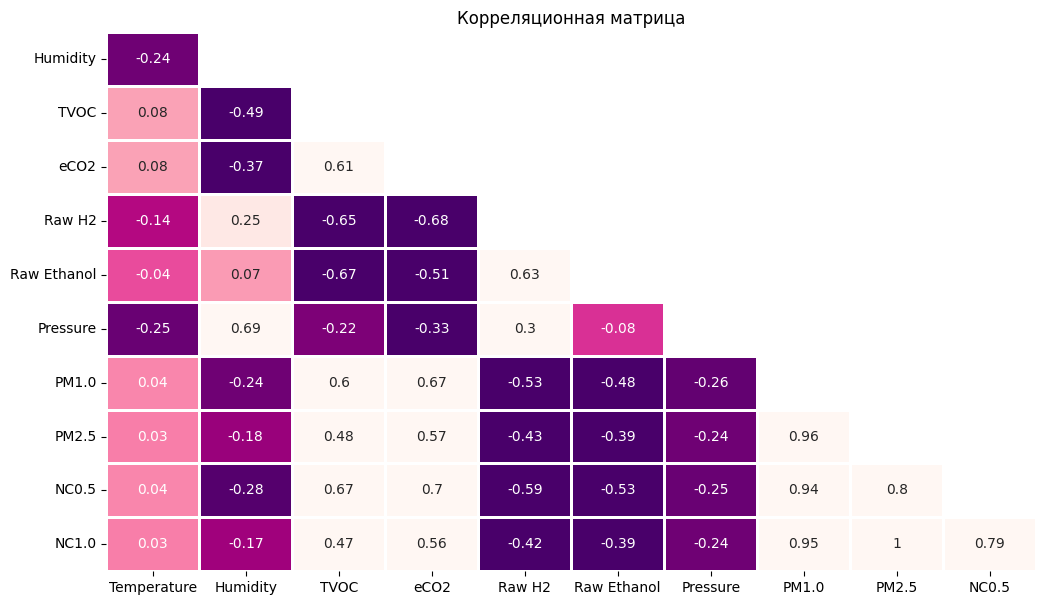

In [ ]:
# теперь посмотрим на корреляцию между данными
corr_mat = X_smoke_std.iloc[:, :-1].corr().round(2)
f, ax = plt.subplots(figsize=(12,7))
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
mask = mask[1:,:-1]
corr = corr_mat.iloc[1:,:-1].copy()
sns.heatmap(corr,mask=mask,vmin=-0.3,vmax=0.3,center=0,
            cmap='RdPu_r',square=False, lw=2, annot=True, cbar=False)
ax.set_title('Корреляционная матрица')

In [ ]:
# видим, что у нас есть данные вида PM и NC, которые очень связаны между собой
# с этим надо что-то делать -- уменьшим его размерность
correlated_cols = ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'eCO2', 'Raw H2']
X_base = X_smoke_std.loc[:,  list(set(X_smoke_std.columns) - set(correlated_cols))]
X_smoke_std_pcad = X_smoke_std.loc[:, correlated_cols]

pca = PCA(n_components=1)
pca.fit(X_smoke_std_pcad)
X_smoke_std_pcad_df = pca.transform(X_smoke_std_pcad)
X_smoke_v2 = X_base.copy()
X_smoke_v2['some_matter'] = X_smoke_std_pcad_df
X_smoke_v2

,Humidity,Temperature,Pressure,TVOC,Raw Ethanol,some_matter
0,0.994921,0.280644,0.831731,-0.248618,-2.025006,0.380548
1,0.917090,0.281689,0.838491,-0.248618,-1.810074,0.342390
2,0.837004,0.282664,0.833984,-0.248618,-1.624673,0.314016
3,0.760301,0.283709,0.832482,-0.248618,-1.485213,0.298361
4,0.693750,0.284753,0.838491,-0.248618,-1.367082,0.285641
...,...,...,...,...,...,...
62625,-3.694088,0.171867,-1.470460,-0.168610,1.336806,-1.004920
62626,-3.685064,0.186839,-1.464451,-0.170274,1.367980,-1.012778
62627,-3.688448,0.201742,-1.457690,-0.168354,1.358135,-1.006960
62628,-3.665889,0.216784,-1.462948,-0.166945,1.331884,-0.994246


## Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smoke_v2, y_smoke, test_size=0.20, random_state=42)

In [ ]:
lg = LogisticRegression(max_iter=400)
lg.fit(X_train, y_train)
preds_lg = lg.predict(X_test)

In [ ]:
# так как у нас в данных есть выбросы воспользуемся метрикой RMSE по причине: у нас жутко аномальные данные

MSE = np.sqrt(mean_squared_error(preds_lg, y_test))
f'{MSE = }' # модель не очень хорошо предсказывает на базовых параметрах

'MSE = 0.3634902744591348'

In [ ]:
eli5.show_weights(lg, feature_names=lg.feature_names_in_)

Weight?,Feature
+1.063,<BIAS>
+0.609,Humidity
-0.290,some_matter
-0.949,Temperature
-1.186,Pressure
-4.091,Raw Ethanol
-7.260,TVOC


In [ ]:
# попробуем теперь бустер
cl = LGBMClassifier()
cl.fit(X_train, y_train)
preds_cl = cl.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35831, number of negative: 14271
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 50102, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715161 -> initscore=0.920584
[LightGBM] [Info] Start training from score 0.920584


In [ ]:
MSE = np.sqrt(mean_squared_error(preds_cl, y_test))
f'{MSE = }' # получился очень низкий MSE - хорошо

'MSE = 0.008934984353292475'

In [ ]:
eli5.show_weights(cl) # Этот алгоритм уже учитывает все данные (влажность причем в последнюю очередь - что доказывает плохость регрессии)

Weight,Feature
0.5296,Pressure
0.2854,TVOC
0.1345,some_matter
0.0235,Temperature
0.0227,Raw_Ethanol
0.0043,Humidity
